# L3: Custom Components - News Summarizer

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [1]:
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

In [2]:
import requests

from typing import List

from haystack import Document, Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

## Custom Component Requirements
#### Build a Custom Component


In [3]:
@component
class Greeter:

    @component.output_types(greeting=str)
    def run(self, user_name: str):
        return {"greeting": f"Hello {user_name}"}

#### Run the Component

In [4]:
greeter = Greeter()

greeter.run(user_name="Tuana")

{'greeting': 'Hello Tuana'}

#### Add the Component to a Pipeline

In [5]:
greeter = Greeter()
template = """ You will be given the beginning of a dialogue. 
Create a short play script using this as the start of the play.
Start of dialogue: {{ dialogue }}
Full script: 
"""
prompt = PromptBuilder(template=template)
llm = OpenAIGenerator()

dialogue_builder = Pipeline()
dialogue_builder.add_component("greeter", greeter)
dialogue_builder.add_component("prompt", prompt)
dialogue_builder.add_component("llm", llm)

dialogue_builder.connect("greeter.greeting", "prompt.dialogue")
dialogue_builder.connect("prompt", "llm")

🚅 Components
  - greeter: Greeter
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - greeter.greeting -> prompt.dialogue (str)
  - prompt.prompt -> llm.prompt (str)

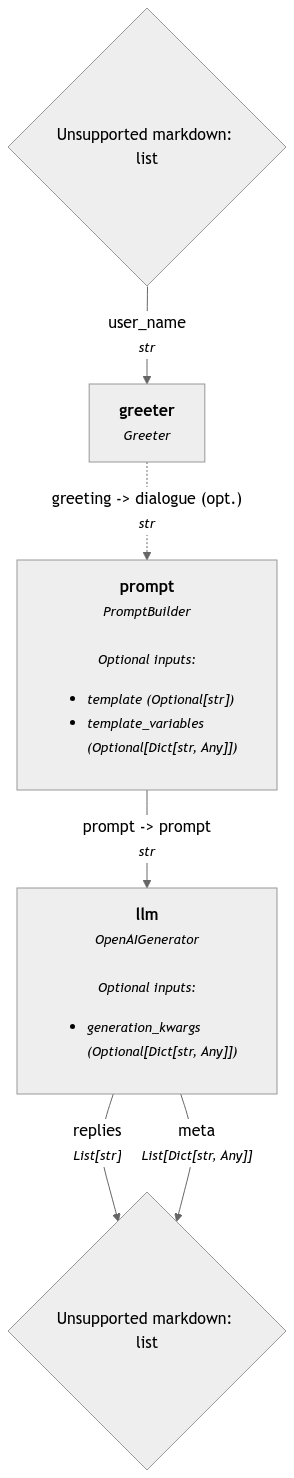

In [6]:
dialogue_builder.show()

In [7]:
dialogue = dialogue_builder.run({"greeter": {"user_name": "Tuana"}})

print(dialogue["llm"]["replies"][0])

Character 1: Hello Tuana
Tuana: Oh, hello there! How are you today?
Character 1: I'm good, thank you. I wanted to talk to you about something.
Tuana: Sure, what's on your mind?
Character 1: Well, I've been thinking about our upcoming project and I was hoping we could collaborate on it together.
Tuana: That sounds like a great idea. I think we would make a great team.
Character 1: I agree. I think our skills and ideas complement each other well. I can't wait to get started on this project with you.
Tuana: Me too. I think we have the potential to create something really special together.
Character 1: I have a few ideas already, but I would love to hear your thoughts as well.
Tuana: Absolutely, let's brainstorm and come up with a plan. I'm excited to see where this collaboration takes us.


## Build a Hacker News Summarizer

> **Note:** Everyone will get different results for this application to what you see in the recording. Results depend on when you run it as it's based on 'current' top/new posts on Hacker News. 

In [8]:
trending_list = requests.get(
        url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
    )
post = requests.get(
    url=f"https://hacker-news.firebaseio.com/v0/item/{trending_list.json()[0]}.json?print=pretty"
)

print(post.json())

{'by': 'dselsam', 'descendants': 26, 'id': 41540902, 'kids': [41541372, 41541665, 41541688, 41541327, 41541690, 41541318, 41541542, 41541387, 41541281], 'score': 112, 'time': 1726332064, 'title': 'Terence Tao on O1', 'type': 'story', 'url': 'https://mathstodon.xyz/@tao/113132502735585408'}


In [9]:
@component
class HackernewsNewestFetcher:
    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        return {"articles": articles}

In [10]:
@component
class HackernewsNewestFetcher:
    def __init__(self):
        fetcher = LinkContentFetcher()
        converter = HTMLToDocument()

        html_conversion_pipeline = Pipeline()
        html_conversion_pipeline.add_component("fetcher", fetcher)
        html_conversion_pipeline.add_component("converter", converter)

        html_conversion_pipeline.connect("fetcher", "converter")
        self.html_pipeline = html_conversion_pipeline
        
    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        trending_list = requests.get(
            url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
        )
        for id in trending_list.json()[0:top_k]:
            post = requests.get(
                url=f"https://hacker-news.firebaseio.com/v0/item/{id}.json?print=pretty"
            )
            if "url" in post.json():
                try:
                    article = self.html_pipeline.run(
                        {"fetcher": {"urls": [post.json()["url"]]}}
                    )
                    articles.append(article["converter"]["documents"][0])
                except:
                    print(f"Can't download {post}, skipped")
            elif "text" in post.json():
                try:
                    articles.append(Document(content=post.json()["text"], meta= {"title": post.json()["title"]}))
                except:
                    print(f"Can't download {post}, skipped")
        return {"articles": articles}

In [11]:
fetcher = HackernewsNewestFetcher()
results = fetcher.run(top_k=3)

print(results['articles'])

[Document(id=29c415c7021cafc07a46af2d131ab816336887a3bd5416f5a26ca5c2ac1e4f49, content: 'To use the Mastodon web application, please enable JavaScript. Alternatively, try one of the
native ...', meta: {'content_type': 'text/html', 'url': 'https://mathstodon.xyz/@tao/113132502735585408'}), Document(id=37777fef09c0cc5c546579b8289f4169bdc6a7d9ba7cf4804931b1bd3fb33efc, content: 'Statistics > Machine Learning
[Submitted on 9 Sep 2024]
Title:LLMs Will Always Hallucinate, and We N...', meta: {'content_type': 'text/html', 'url': 'https://arxiv.org/abs/2409.05746'}), Document(id=6d0de949a219eb77a980dab76d6b30cd43715cbdebecc3417c554ac93b70cca9, content: 'Here’s a puzzle: how do you create a trillion-dollar debt bubble that can’t be popped? Answer: make ...', meta: {'content_type': 'text/html', 'url': 'https://anandsanwal.me/college-student-debt-deception/'})]


In [12]:
prompt_template = """  
You will be provided a few of the top posts in HackerNews.  
For each post, provide a brief summary if possible.
  
Posts:  
{% for article in articles %}
  Post:\n
  {{ article.content}}
{% endfor %}  
"""

In [13]:
prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = OpenAIGenerator()

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.prompt (str)

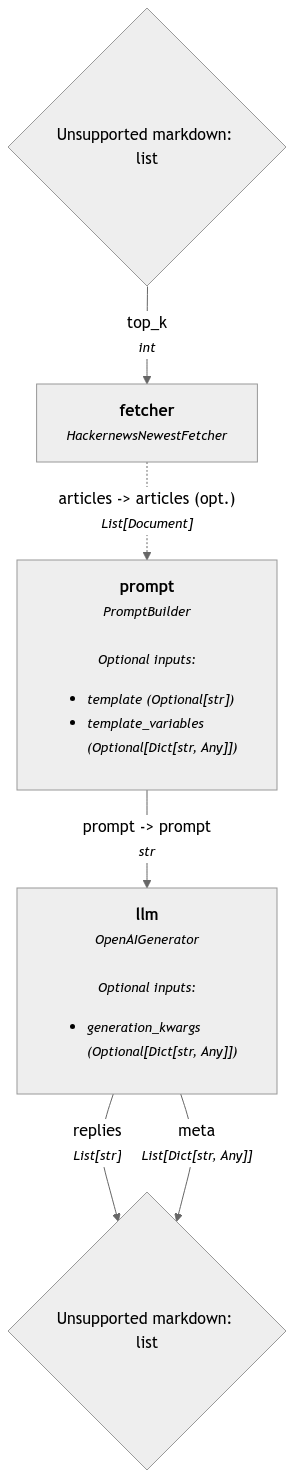

In [14]:
summarizer_pipeline.show()

In [15]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 3}})

print(summaries["llm"]["replies"][0])

Summary: This post discusses the student loan debt crisis in the U.S. It highlights the issues with non-dischargeable student loans, how it has led to a trillion-dollar debt bubble, and the challenges in fixing the system. The post argues that the current system rewards failure and punishes success, while powerful interests profit from the status quo. It proposes solutions such as making loans dischargeable, tying lending to degree value, and holding institutions accountable. The post also examines the impacts of student loan debt on individuals, the economy, and generations.


In [16]:
prompt_template = """  
You will be provided a few of the top posts in HackerNews, followed by their URL.  
For each post, provide a brief summary followed by the URL the full post can be found at.  
  
Posts:  
{% for article in articles %}  
  {{ article.content }}
  URL: {{ article.meta["url"] }}
{% endfor %}  
"""

prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = OpenAIGenerator()

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.prompt (str)

In [17]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 2}})

print(summaries["llm"]["replies"][0])

Summary: The post discusses the inevitability of hallucinations in Large Language Models (LLMs) due to their fundamental mathematical and logical structure. It argues that hallucinations cannot be fully eliminated through architectural improvements, dataset enhancements, or fact-checking mechanisms. The concept of Structural Hallucination is introduced as an intrinsic nature of these systems, challenging the notion that they can be completely mitigated.

URL: https://arxiv.org/abs/2409.05746


### Extra resources! 

Learn more about the Haystack integrations:

* [deepset-ai github repo](https://github.com/deepset-ai/haystack-integrations)
* [haystack.deepset.ai/integrations](https://haystack.deepset.ai/integrations)